# Exploratory data analysis on Season 2 results

I'm curious about the players' music preferences and how they might be clustered. Also of interest is how strategy can be optimized amongst these players. For example, if I liked song $k$ on week $n$, was it likely to have been submitted by Player $X$? (Furthermore, should I sabatoge my scoring preferences if I believe that Player $X$ is currently winning the game?)

I'm also just interested in how to analyze data that are (a) sparse, (b) human-biased, and (c) come in the abhorrent format of spreadsheets with tabs. Just kidding about that last one (although it would benefit me to learn some proper Excel file I/O).

*Update: I have created a cleaned version of the spreadsheet in which I've changed:* 
- all guest submitters + `nikita` become `guest`
- homogenize `chris` and `c h r i s`
- change one instance of `jonathan` to `watchwolf92`
- fixe two misspellings of `pseudo`.
- erase `nikita`'s votes during the first week, as they'll screw up any clustering analysis.
- re-order index in week 3 because it screws up votes, and remove `nikita` again

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
% matplotlib inline

print('Note that I am using Pandas version {}'.format(pd.__version__))

Note that I am using Pandas version 0.22.0


In [2]:
# directory info
root_dir = os.path.join(os.getcwd(), '..')
data_dir = os.path.join(root_dir, 'data')
results_dir = os.path.join(root_dir, 'results')

In [3]:
# constants and file organization
num_weeks = 10
num_players = 8 

fname = os.path.join(data_dir, 'season2_cleaned.xlsx')

In [4]:
df = pd.read_excel(fname, sheet_name=0)
df

,song name,submitter,gold,silver,bronze,total,total w/ bonus,recognize count,vote gold,vote silver,vote bronze,rec
1,saigo no bansan - radwimps,stvntol,3.0,1.0,NaN,11,14,NaN,2,4,8,NaN
2,frederic - oddloop,watchwolf92,1.0,1.0,1.0,6,9,NaN,1,6,3,NaN
3,taeyeon - 11:11,pseudo,1.0,NaN,1.0,4,7,NaN,1,8,5,NaN
4,Summer Solstice - Moonlit Sailor,chris,NaN,2.0,2.0,6,9,NaN,1,8,2,8.0
5,Phoria-Melatonin,guest,NaN,NaN,1.0,1,4,NaN,6,4,8,NaN
6,Lifting The Seas-Hunt,jwuphysics,2.0,1.0,NaN,8,11,NaN,8,7,4,NaN
7,A Fine Frenzy,citrus,NaN,1.0,NaN,2,5,NaN,3,1,8,NaN
8,Emancipator,gracebunella,1.0,2.0,3.0,10,10,1.0,6,2,4,NaN


## Data cleaning

Let's remove the bottom row, which seems to only be a line for error-checking. Recognized songs technically came with a penalty, but I won't consider that here. ~~We'll also remove the player `nikita`, who dropped out after week 1.~~ ~~Since every week there was an extra player, whether it be `nikita`, who did not finish, or a guest, I'll have to remove that data.~~ I am keeping guest submissions because they have voten votes.

In [5]:
# get relevant columns
names = ['player', 'votegold', 'votesilver', 'votebronze']
col_nums = [2, 9, 10, 11]

df = pd.read_excel(fname, sheet_name=0, names=names, usecols=col_nums)
df.set_index('player', inplace=True)
df

,votegold,votesilver,votebronze
player,,,
stvntol,2,4,8
watchwolf92,1,6,3
pseudo,1,8,5
chris,1,8,2
guest,6,4,8
jwuphysics,8,7,4
citrus,3,1,8
gracebunella,6,2,4


In [6]:
# enumerate the players (note 0-index)
players = df.index.values
player_ids = dict(zip(players, np.arange(num_players + 1)))

for player, i in player_ids.items():
    print('{} {}'.format(i, player))
    

0 stvntol
1 watchwolf92
2 pseudo
3 chris
4 guest
5 jwuphysics
6 citrus
7 gracebunella


In [7]:
# now make vectors for each player's vote
vote_matrix = np.zeros((num_players, num_players))

# cast votes
for player, [votegold, votesilver, votebronze] in df.iterrows():
    try:
        player_id = player_ids[player]
    except KeyError:
        player_id = 4 # guest

    vote_matrix[player_id, votegold-1] += 3
    vote_matrix[player_id, votesilver-1] += 2
    vote_matrix[player_id, votebronze-1] += 1

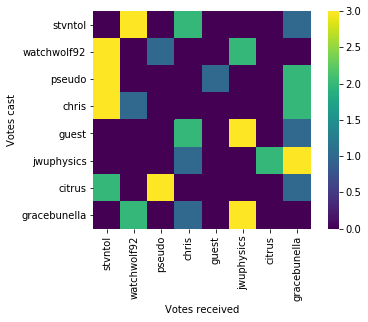

In [8]:
sns.heatmap(vote_matrix, xticklabels=players, yticklabels=players, square=True, cmap='viridis')
plt.xlabel('Votes received')
plt.ylabel('Votes cast');

### See all votes

In [90]:
def invert_permutation(players_1, players_2):
    """Given lists of strings `players_1` and `players_2`, which must
    be permutations of one another, returns indices [i0, i1, ...] such
    that players1[j] is the same as players2[indices[j]].
    """
    return np.array([np.argwhere(player==players_2)[0,0] for player in players_1])

In [137]:
# convenience function
def organize_votes(df):
    """Takes in a Pandas dataframe indexed by player names. Columns should be 
    IDs of the players for whom the indexed player voted. Returns a vote matrix
    similar to the one seen above.
    """
    
    df.set_index('player', inplace=True)
    df.dropna(axis='index', how='all')
   
    # save old indices in order to map votes
    player_mapping = invert_permutation(df.index.values, players)
    
    df = df.reindex(players)
    
    # impute 0s to NaNs and then int-cast
    df.fillna(value=0, inplace=True)
    df = df.astype(int)

    # record votes (note that the guest ID is always 4)
    vote_matrix = np.zeros((num_players, num_players))
        
    for player, [votegold, votesilver, votebronze] in df.iterrows():
        
        player_id = player_ids[player]
        
        if player == 'guest':
            continue
        
        vote_matrix[player_id, player_mapping[votegold-1]] += 3
        vote_matrix[player_id, player_mapping[votesilver-1]] += 2
        vote_matrix[player_id, player_mapping[votebronze-1]] += 1    
    
    return vote_matrix

In [138]:
# in case these got overwritten somehow
fname = os.path.join(data_dir, 'season2_cleaned.xlsx')
names = ['player', 'votegold', 'votesilver', 'votebronze']
col_nums = [2, 9, 10, 11]

# store results in a 3d array
vote_array = np.zeros((num_weeks, num_players, num_players))

for k in range(num_weeks):
    df = pd.read_excel(fname, sheet_name=k, names=names, usecols=col_nums)

    vote_array[k] = organize_votes(df)

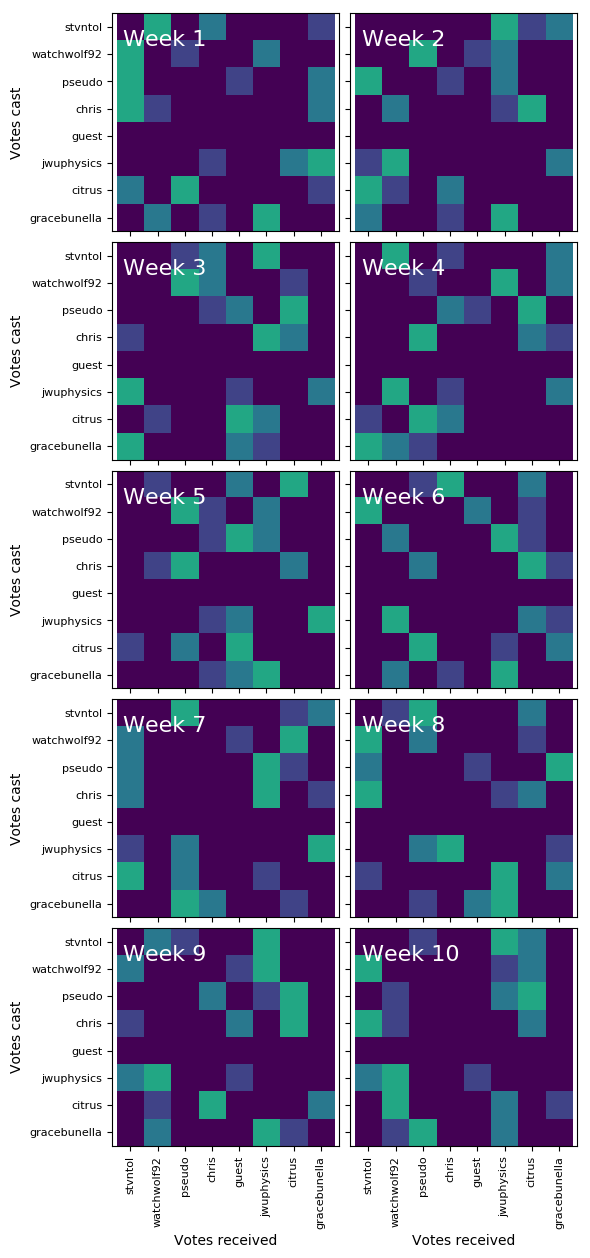

In [139]:
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(3*num_cols, 3*num_rows), dpi=100)

for k, [vote_matrix, ax] in enumerate(zip(vote_array, axes.flat)):
    ax.imshow(vote_matrix, cmap='viridis', vmax=5)
    
    if k % num_cols == 0:
        ax.set_ylabel('Votes cast')
        ax.set_yticks(range(num_players))
        ax.set_yticklabels(players, fontsize=8)
    if k // num_cols == num_rows - 1:
        ax.set_xlabel('Votes received')
        ax.set_xticks(range(num_players))
        ax.set_xticklabels(players, rotation=90, fontsize=8)
    
    # label
    ax.text(0.05, 0.85, 'Week {}'.format(k+1), fontsize=16, color='white', transform=ax.transAxes)
    
fig.subplots_adjust(hspace=0.05, wspace=0.05)

Text(83.4,0.5,'Votes cast')

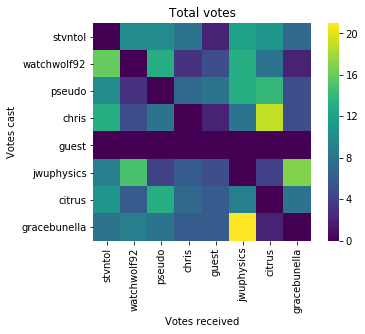

In [145]:
# total score
summed_votes = np.sum(vote_array, axis=0)
sns.heatmap(summed_votes, xticklabels=players, yticklabels=players, square=True, cmap='viridis')
plt.title('Total votes')
plt.xlabel('Votes received')
plt.ylabel('Votes cast')


We expect a traceless matrix:

In [147]:
print('The trace of the summed votes is {}'.format(np.trace(summed_votes)))

The trace of the summed votes is 0.0


Success! Now we can do some real statistics.